In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
ruta_archivo = 'C:/Users/juans/Documents/MCD/1-materias/laboratorio III/TP_final/labo3/data/sell-in.txt'
ruta_archivo_predicccion = 'C:/Users/juans/Documents/MCD/1-materias/laboratorio III/TP_final/labo3/data/product_id_apredecir201912.txt'
df = pd.read_csv(ruta_archivo, sep='\t')
df_1 = pd.read_csv(ruta_archivo_predicccion, sep='\t')

#Variables y tipos:

In [3]:
print(f'Filas y columnas: {df.shape}')
print('\nTipos de datos:\n', df.dtypes)
# df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")

Filas y columnas: (2945818, 7)

Tipos de datos:
 periodo                    int64
customer_id                int64
product_id                 int64
plan_precios_cuidados      int64
cust_request_qty           int64
cust_request_tn          float64
tn                       float64
dtype: object


In [ ]:
print(f'Filas y columnas: {df.shape}')
df.head(3)

Filas y columnas: (2945818, 7)


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028


In [ ]:
print(f'Filas y columnas: {df_1.shape}')
df_1.head(3)


Filas y columnas: (780, 1)


,product_id
0,20001
1,20002
2,20003


In [ ]:
import duckdb

# DataFrames son df y df_1
consulta = """
SELECT d.product_id, SUM(d.tn) AS total_tn
FROM df d
JOIN df_1 f ON d.product_id = f.product_id
WHERE d.periodo = 201912
GROUP BY d.product_id
ORDER BY d.product_id
"""
resultado_sql = duckdb.query(consulta).to_df()
resultado_sql.shape


(780, 2)

In [ ]:
df_1.shape

(780, 1)

In [ ]:
filtro = df['periodo'] == 201912
df_filtrado = df.loc[filtro, ['product_id', 'tn']]
filtro.shape

(2945818,)

In [ ]:
# Prediccion Feb 2020 igual a 2019-12

filtro = df['periodo'] == 201912
df_filtrado = df.loc[filtro, ['product_id', 'tn']]
df_filtrado = df_filtrado[df_filtrado['product_id'].isin(df_1['product_id'])]
df_agrupado = df_filtrado.groupby('product_id', as_index=False)['tn'].sum()
resultado = df_1.merge(df_agrupado, on='product_id', how='left')
resultado['tn'] = resultado['tn'].fillna(0)  # opcional

resultado.to_csv('resultado0001.csv', index=False)
print(resultado.shape)
resultado.head()



(780, 2)


,product_id,tn
0,20001,1504.68856
1,20002,1087.30855
2,20003,892.50129
3,20004,637.90002
4,20005,593.24443


In [ ]:
# Filtramos los 3 meses y productos que están en df_1
filtro = df['periodo'].isin([201910, 201911, 201912])
df_filtrado = df.loc[filtro, ['periodo', 'product_id', 'tn']]
df_filtrado = df_filtrado[df_filtrado['product_id'].isin(df_1['product_id'])]

# Primero agrupamos por mes y producto para obtener la suma mensual por producto
df_suma_mensual = df_filtrado.groupby(['product_id', 'periodo'], as_index=False)['tn'].sum()

# Luego agrupamos por producto para obtener la media de los totales mensuales
df_media_mensual = df_suma_mensual.groupby('product_id', as_index=False)['tn'].mean()

# Hacemos merge con df_1 (LEFT JOIN) y rellenamos NaN con 0 si es necesario
resultado = df_1.merge(df_media_mensual, on='product_id', how='left')
resultado['tn'] = resultado['tn'].fillna(0)  # Opcional

resultado.to_csv('resultado0002.csv', index=False)
print(resultado.shape)
resultado.head()

(780, 2)


,product_id,tn
0,20001,1487.855463
1,20002,1496.807430
2,20003,974.053890
3,20004,808.846137
4,20005,732.312970


In [ ]:
# DataFrames de entrada: df (datos mensuales) y df_1 (maestro de productos)

# Definimos los períodos de interés
rangos = {
    "ultimos_3": [201910, 201911, 201912],
    "ultimos_6": [201907, 201908, 201909, 201910, 201911, 201912],
    "ultimos_9": list(range(201904, 201913)),  # últimos 9 meses
    "ultimos_12": list(range(201901, 201913))  # Todos los meses del 2019 (201901 a 201912)
}

In [ ]:
def calcular_promedio_movil(df, df_1, meses):
    # Filtramos los meses y productos que están en df_1
    df_filtrado = df[df['periodo'].isin(meses) & df['product_id'].isin(df_1['product_id'])]

    # PRIMERO: Suma mensual por producto (agrupamos por producto y mes)
    df_suma_mensual = df_filtrado.groupby(['product_id', 'periodo'], as_index=False)['tn'].sum()

    # SEGUNDO: Promedio de los totales mensuales por producto
    df_promedio = df_suma_mensual.groupby('product_id', as_index=False)['tn'].mean()

    # Merge con df_1 (LEFT JOIN) para mantener todos los productos
    resultado = df_1.merge(df_promedio, on='product_id', how='left')
    resultado['tn'] = resultado['tn'].fillna(0)  # Rellenamos NaN con 0 si es necesario

    return resultado

In [ ]:
# Diccionario para almacenar los resultados
resultados = {}

for nombre_rango, meses in rangos.items():
    resultados[nombre_rango] = calcular_promedio_movil(df, df_1, meses)
    resultados[nombre_rango].to_csv(f'promedio_{nombre_rango}.csv', index=False)
    print(f"\nResultado para {nombre_rango}:")
    print(resultados[nombre_rango].head())
    print(f"Filas y columnas: {resultados[nombre_rango].shape}")


Resultado para ultimos_3:
   product_id           tn
0       20001  1487.855463
1       20002  1496.807430
2       20003   974.053890
3       20004   808.846137
4       20005   732.312970
Filas y columnas: (780, 2)

Resultado para ultimos_6:
   product_id           tn
0       20001  1510.651745
1       20002  1243.473690
2       20003   873.455267
3       20004   702.759787
4       20005   726.480795
Filas y columnas: (780, 2)

Resultado para ultimos_9:
   product_id           tn
0       20001  1494.585441
1       20002  1190.202131
2       20003   784.286781
3       20004   661.530294
4       20005   750.838167
Filas y columnas: (780, 2)

Resultado para ultimos_12:
   product_id           tn
0       20001  1454.732720
1       20002  1175.437142
2       20003   784.976407
3       20004   627.215328
4       20005   668.270104
Filas y columnas: (780, 2)


In [ ]:
# Definimos los parámetros
rangos_meses = {
    "ultimos_3": [201910, 201911, 201912],
    "ultimos_6": [201907, 201908, 201909, 201910, 201911, 201912],
    "ultimos_9": list(range(201904, 201913)),  # Abril a Diciembre 2019
    "ultimos_12": list(range(201901, 201913))  # Enero a Diciembre 2019
}

multiplicadores = [0.98, 0.99, 1.01, 1.02]

# Función modificada que calcula promedio de sumas mensuales
def calcular_promedio_ajustado(df, df_1, meses, multiplicador):
    # Filtramos los datos
    df_filtrado = df[df['periodo'].isin(meses) & df['product_id'].isin(df_1['product_id'])]

    # PRIMERO: Suma mensual por producto
    df_suma_mensual = df_filtrado.groupby(['product_id', 'periodo'], as_index=False)['tn'].sum()

    # SEGUNDO: Promedio de los totales mensuales
    df_promedio = df_suma_mensual.groupby('product_id', as_index=False)['tn'].mean()

    # Aplicamos el multiplicador
    df_promedio['tn_ajustado'] = df_promedio['tn'] * multiplicador

    # Merge con df_1
    resultado = df_1.merge(df_promedio[['product_id', 'tn_ajustado']], on='product_id', how='left')
    resultado['tn_ajustado'] = resultado['tn_ajustado'].fillna(0)

    return resultado

# Generamos los 16 archivos
for nombre_rango, meses in rangos_meses.items():
    for mult in multiplicadores:
        # Calculamos el promedio ajustado
        resultado = calcular_promedio_ajustado(df, df_1, meses, mult)

        # Nombre del archivo: "promedio_ultimos_3_098.csv"
        nombre_archivo = f"promedio_{nombre_rango}_{str(mult).replace('.', '')}.csv"
        resultado.to_csv(nombre_archivo, index=False)

        print(f"Archivo generado: {nombre_archivo} - Shape: {resultado.shape}")

print("¡Proceso completado! Se generaron 16 archivos.")

Archivo generado: promedio_ultimos_3_098.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_3_099.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_3_101.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_3_102.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_6_098.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_6_099.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_6_101.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_6_102.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_9_098.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_9_099.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_9_101.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_9_102.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_12_098.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_12_099.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_12_101.csv - Shape: (780, 2)
Archivo generado: promedio_ultimos_12_102.csv - Shap

#Valores nulos y duplicados:


In [ ]:
print('\nValores nulos:\n', df.isnull().sum())
print('\nValores duplicados:\n', df.duplicated().sum())


Valores nulos:
 periodo                  0
customer_id              0
product_id               0
plan_precios_cuidados    0
cust_request_qty         0
cust_request_tn          0
tn                       0
dtype: int64

Valores duplicados:
 0


,periodo
0,False
1,False
2,False
3,False
4,False


In [ ]:
df_filtrado.head()


,product_id,tn


In [ ]:
df_filtrado = df[df['product_id'].isin(df_1['product_id'])]

print(df_filtrado)

         periodo  customer_id  product_id  plan_precios_cuidados  \
0         201701        10234       20524                      0   
1         201701        10032       20524                      0   
2         201701        10217       20524                      0   
3         201701        10125       20524                      0   
4         201701        10012       20524                      0   
...          ...          ...         ...                    ...   
2945813   201912        10105       20853                      0   
2945814   201912        10092       20853                      0   
2945815   201912        10006       20853                      0   
2945816   201912        10018       20853                      0   
2945817   201912        10020       20853                      0   

         cust_request_qty  cust_request_tn       tn  
0                       2          0.05300  0.05300  
1                       1          0.13628  0.13628  
2                    

In [ ]:
df['año'] = df['periodo'].dt.year
df['mes'] = df['periodo'].dt.month
# Convertir 'periodo' a string con formato YYYY-MM para el eje x del gráfico
df['mes_año'] = df['periodo'].dt.strftime('%Y-%m')

#A. Distribución de toneladas vendidas

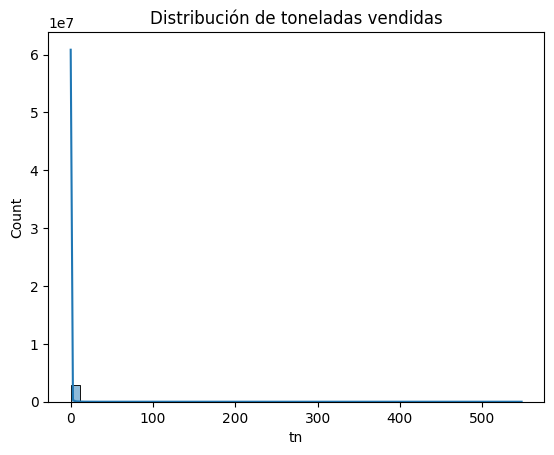

In [ ]:
sns.histplot(df["tn"], bins=50, kde=True)
plt.title("Distribución de toneladas vendidas")
plt.show()

#B. Ventas en el tiempo (agregado mensual)


<Axes: title={'center': 'Toneladas vendidas por mes'}, xlabel='periodo'>

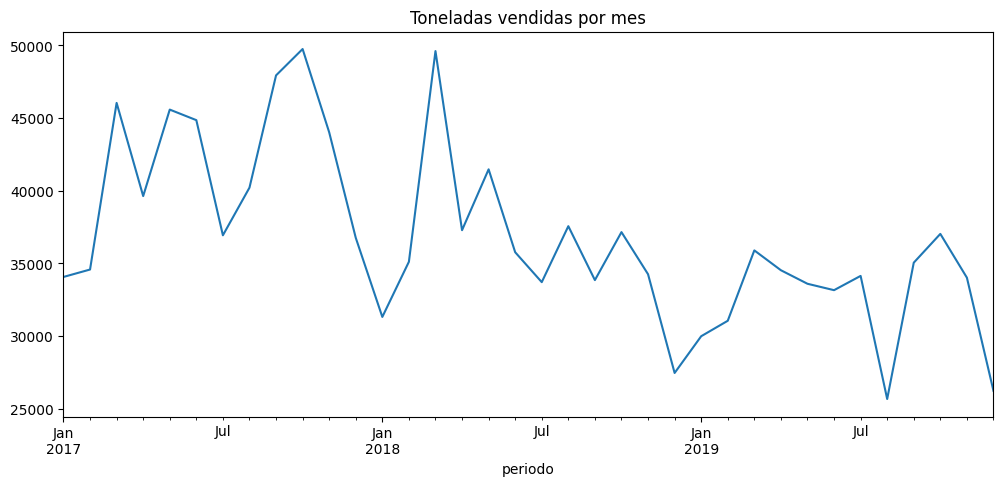

In [ ]:
ventas_mensuales = df.groupby("periodo")["tn"].sum()
ventas_mensuales.plot(figsize=(12, 5), title="Toneladas vendidas por mes")


#C. Top productos y clientes

<Axes: title={'center': 'Top 10 clientes por toneladas vendidas'}, xlabel='customer_id'>

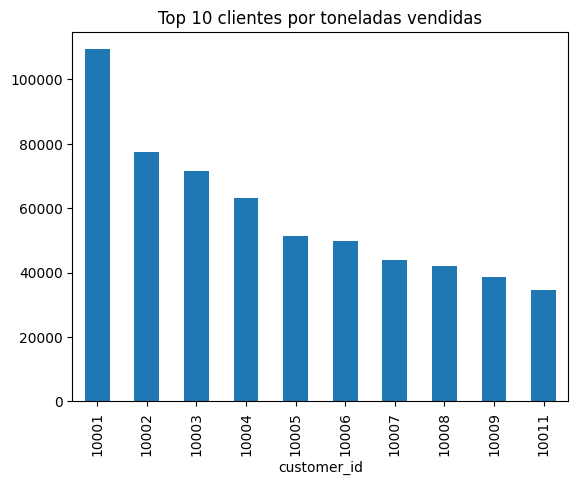

In [ ]:
top_productos = df.groupby("product_id")["tn"].sum().sort_values(ascending=False).head(10)
top_clientes = df.groupby("customer_id")["tn"].sum().sort_values(ascending=False).head(10)
top_productos.plot(kind="bar", title="Top 10 productos por toneladas vendidas")
top_clientes.plot(kind="bar", title="Top 10 clientes por toneladas vendidas")


#D. Efecto del plan precios cuidados

<Axes: title={'center': 'Toneladas vendidas según precios cuidados'}, xlabel='plan_precios_cuidados'>

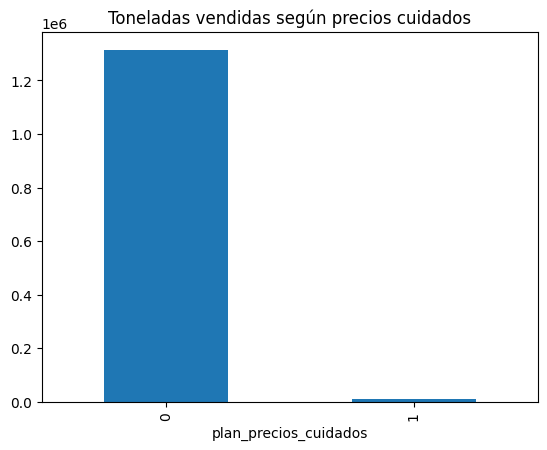

In [ ]:
df.groupby("plan_precios_cuidados")["tn"].sum().plot(kind="bar", title="Toneladas vendidas según precios cuidados")


##E. Comparación de lo solicitado vs lo entregado


<Axes: xlabel='plan_precios_cuidados', ylabel='ratio_entregado_solicitado'>

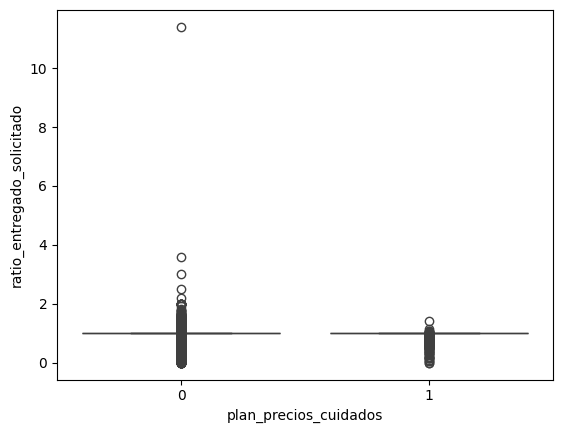

In [ ]:
df["ratio_entregado_solicitado"] = df["tn"] / df["cust_request_tn"]
sns.boxplot(data=df, x="plan_precios_cuidados", y="ratio_entregado_solicitado")


#**1. Análisis Temporal**
##Serie Temporal Mensual

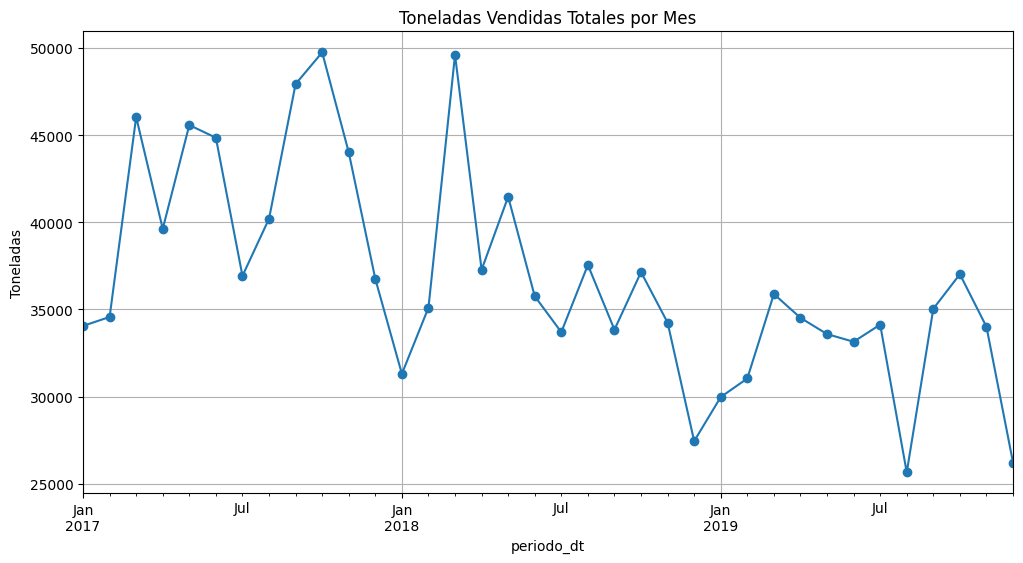

In [ ]:
# Convertir 'periodo' a datetime
df['periodo_dt'] = pd.to_datetime(df['periodo'], format='%Y%m')

# Gráfico de evolución mensual
plt.figure(figsize=(12, 6))
df.groupby('periodo_dt')['tn'].sum().plot(title='Toneladas Vendidas Totales por Mes', marker='o')
plt.ylabel('Toneladas')
plt.grid(True)
plt.show()

##Descomposición de la Serie Temporal

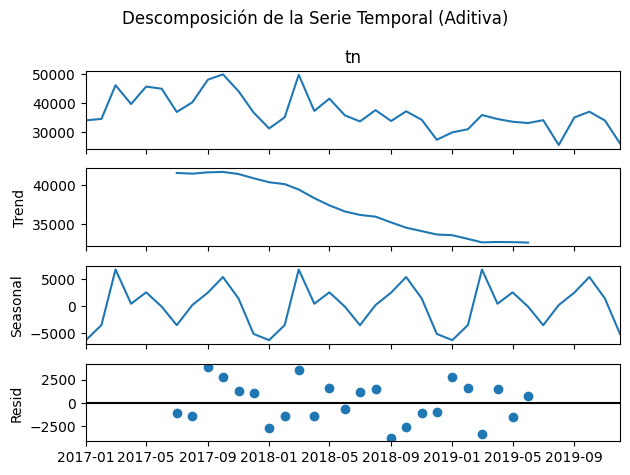

In [ ]:
# Preparar datos para descomposición
ts = df.groupby('periodo_dt')['tn'].sum()

# Descomposición aditiva
decompose_result = seasonal_decompose(ts, model='additive', period=12)
decompose_result.plot()
plt.suptitle('Descomposición de la Serie Temporal (Aditiva)')
plt.tight_layout()
plt.show()

#Boxplot por Mes/Año

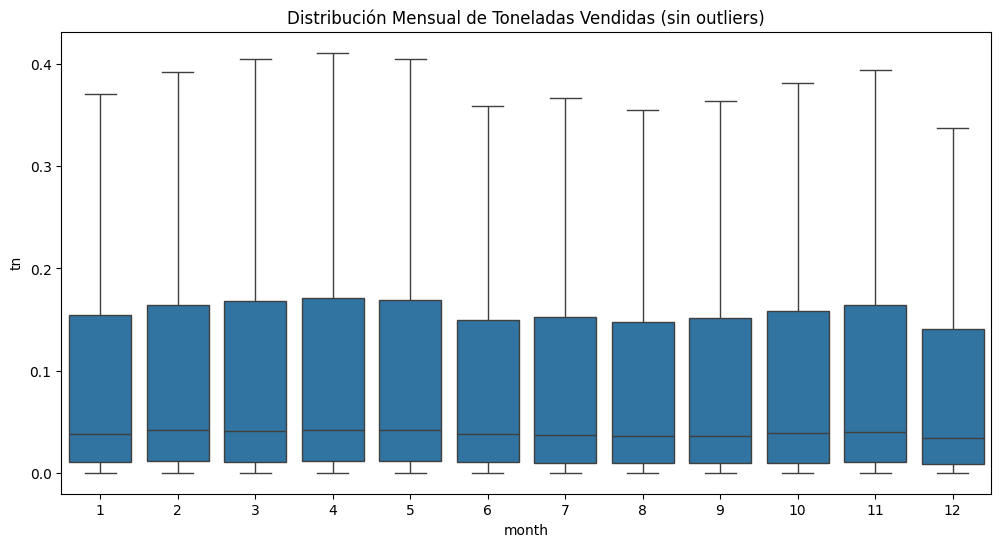

In [ ]:
# Extraer año y mes
df['year'] = df['periodo_dt'].dt.year
df['month'] = df['periodo_dt'].dt.month

# Boxplot por mes
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month', y='tn', showfliers=False)  # showfliers=False para excluir outliers
plt.title('Distribución Mensual de Toneladas Vendidas (sin outliers)')
plt.show()

#**2. Distribución de tn**
##Histograma + KDE

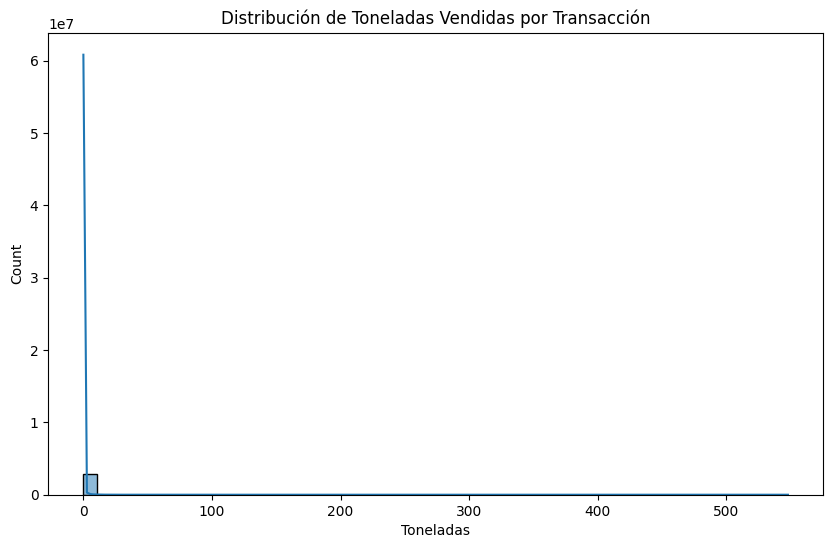

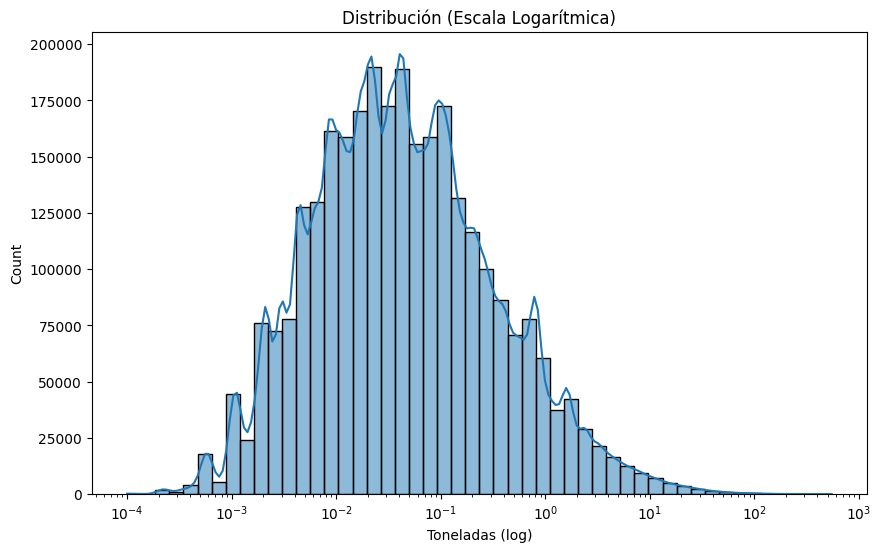

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['tn'], kde=True, bins=50, log_scale=False)
plt.title('Distribución de Toneladas Vendidas por Transacción')
plt.xlabel('Toneladas')
plt.show()

# Versión logarítmica (útil si hay valores extremos)
plt.figure(figsize=(10, 6))
sns.histplot(df['tn'], kde=True, bins=50, log_scale=True)
plt.title('Distribución (Escala Logarítmica)')
plt.xlabel('Toneladas (log)')
plt.show()

##Estadísticos Clave

In [ ]:
print(df['tn'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))
print(f"\nSkewness: {df['tn'].skew():.2f}, Kurtosis: {df['tn'].kurtosis():.2f}")

count    2.945818e+06
mean     4.497863e-01
std      3.108355e+00
min      1.000000e-04
1%       7.900000e-04
5%       2.090000e-03
25%      1.027000e-02
50%      3.931000e-02
75%      1.572500e-01
95%      1.568390e+00
99%      7.434700e+00
max      5.478785e+02
Name: tn, dtype: float64

Skewness: 39.58, Kurtosis: 3068.62


#**3. Relación entre Variables**
##Scatterplot: cust_request_qty vs tn

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


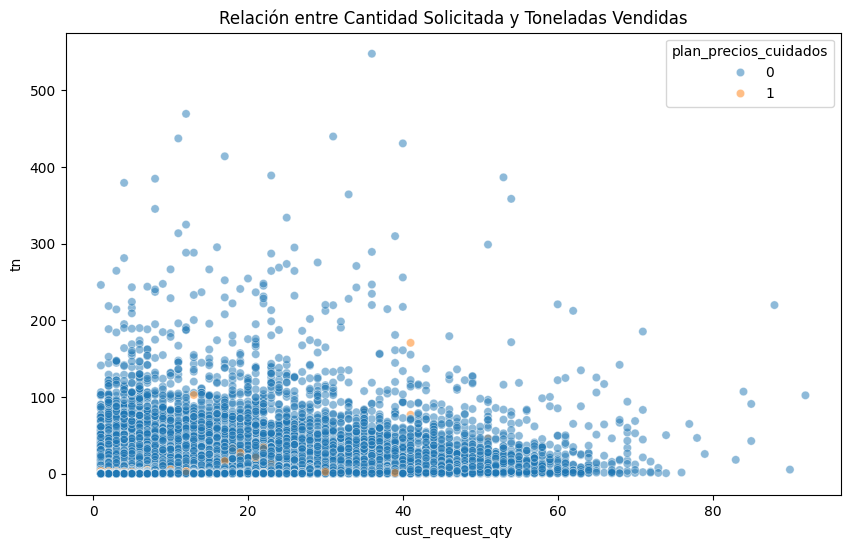

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='cust_request_qty', y='tn', alpha=0.5, hue='plan_precios_cuidados')
plt.title('Relación entre Cantidad Solicitada y Toneladas Vendidas')
plt.show()

##Boxplot: tn por plan_precios_cuidados

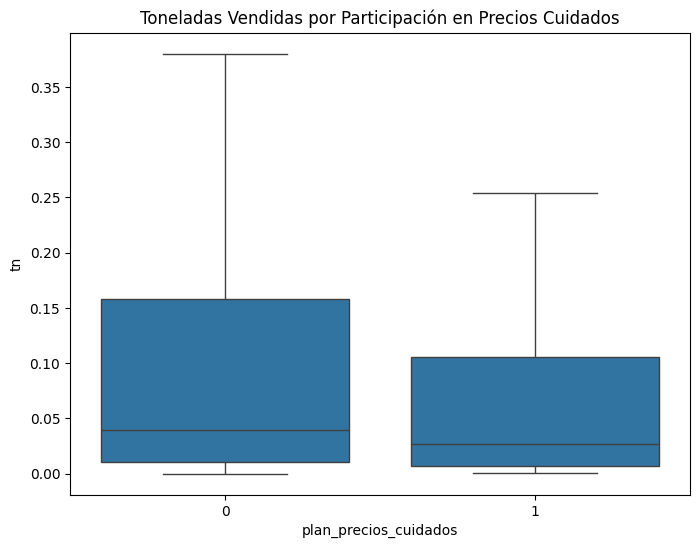

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='plan_precios_cuidados', y='tn', showfliers=False)
plt.title('Toneladas Vendidas por Participación en Precios Cuidados')
plt.show()

##Heatmap de Correlaciones

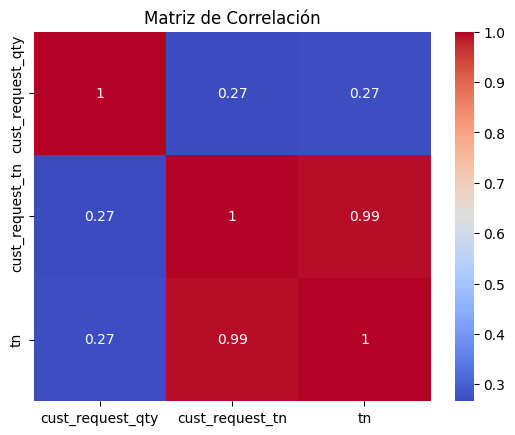

In [ ]:
corr_matrix = df[['cust_request_qty', 'cust_request_tn', 'tn']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

#**4. Análisis por Cliente y Producto**
##Top 20 Clientes

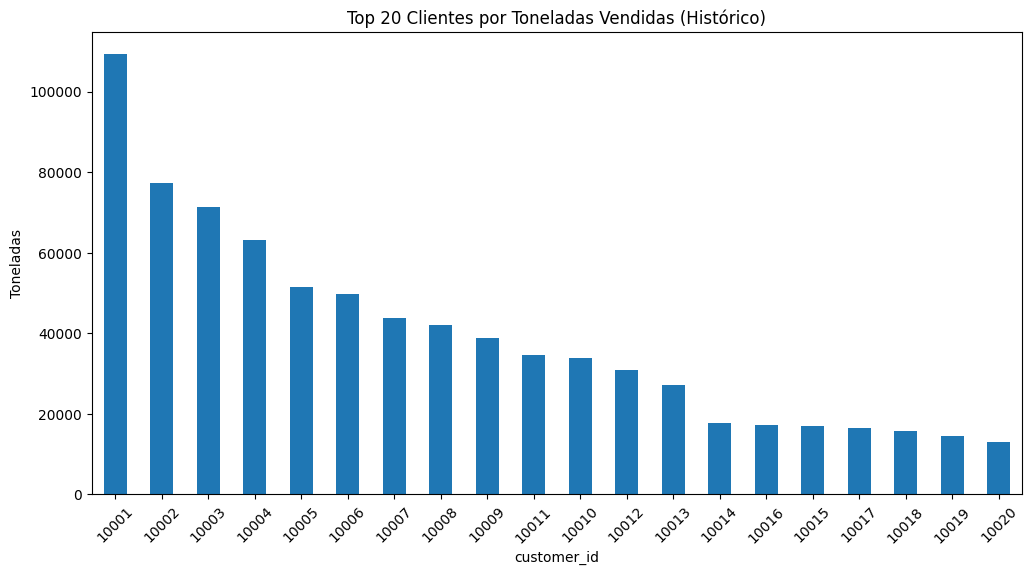

In [ ]:
top_clientes = df.groupby('customer_id')['tn'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 6))
top_clientes.plot(kind='bar')
plt.title('Top 20 Clientes por Toneladas Vendidas (Histórico)')
plt.ylabel('Toneladas')
plt.xticks(rotation=45)
plt.show()

#**5. Análisis de Outliers y Ceros**
##Registros con tn = 0

In [ ]:
ceros = df[df['tn'] == 0]
print(f"% de registros con tn=0: {len(ceros)/len(df)*100:.2f}%")

% de registros con tn=0: 0.00%


##Scatterplot con Log-Scale

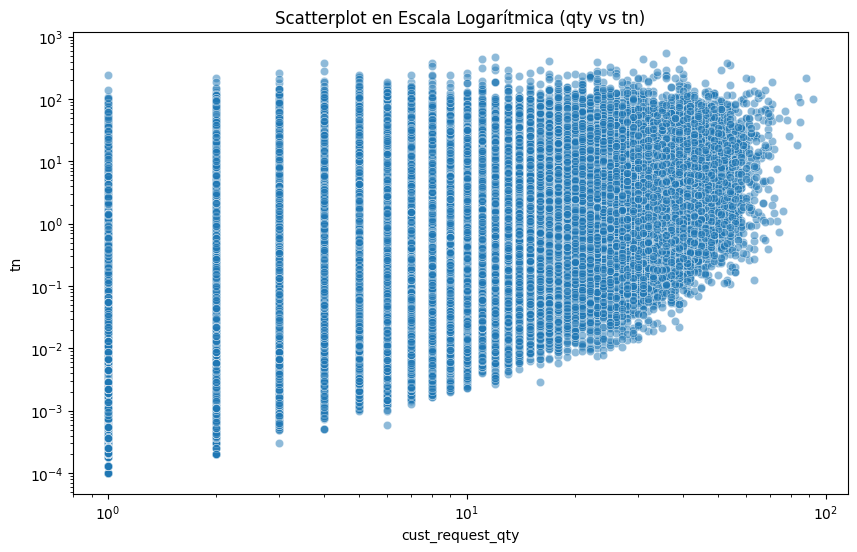

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='cust_request_qty', y='tn', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Scatterplot en Escala Logarítmica (qty vs tn)')
plt.show()

#**6. Precios Cuidados**
##Serie Temporal Comparativa

<Figure size 1200x600 with 0 Axes>

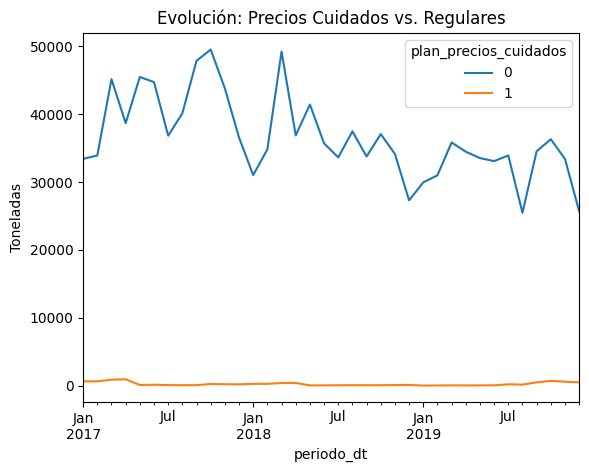

In [ ]:
plt.figure(figsize=(12, 6))
df.groupby(['periodo_dt', 'plan_precios_cuidados'])['tn'].sum().unstack().plot()
plt.title('Evolución: Precios Cuidados vs. Regulares')
plt.ylabel('Toneladas')
plt.show()

##Cambio en Participación de Mercado

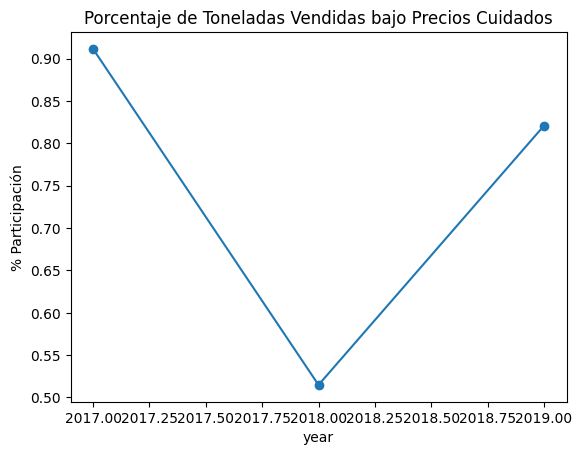

In [ ]:
participacion = df.groupby(['year', 'plan_precios_cuidados'])['tn'].sum().unstack()
participacion['total'] = participacion.sum(axis=1)
participacion['%_cuidados'] = (participacion[1] / participacion['total']) * 100

participacion['%_cuidados'].plot(marker='o')
plt.title('Porcentaje de Toneladas Vendidas bajo Precios Cuidados')
plt.ylabel('% Participación')
plt.show()

# **7. Ventas anuales**
##Ventas mensuales por toneladas (2017 - 2019)

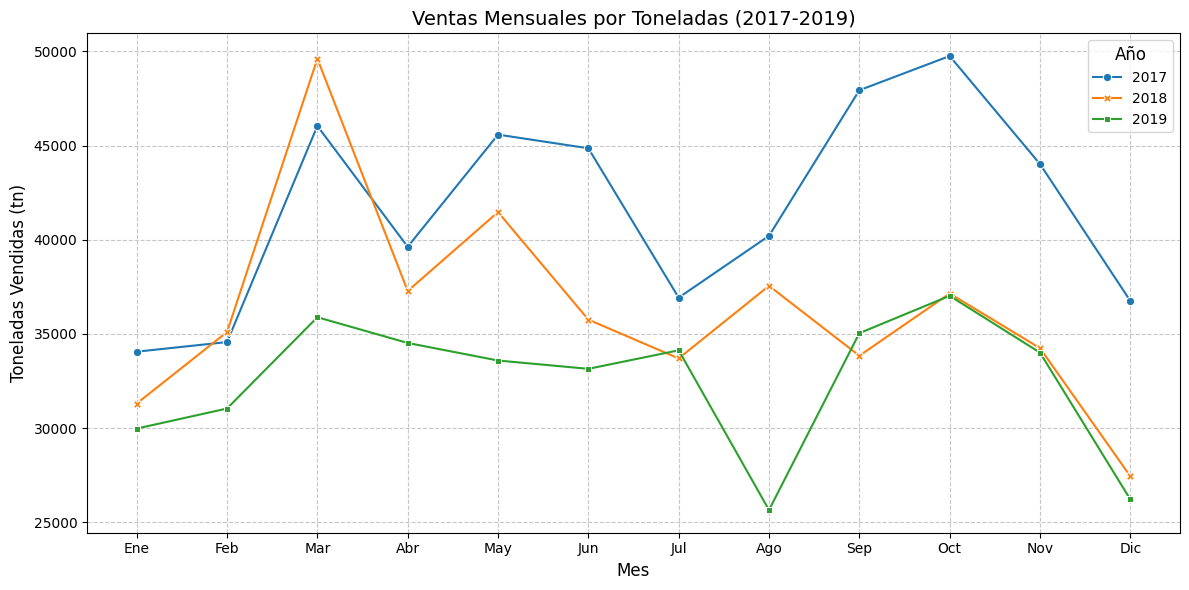

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
# plt.style.use('seaborn')
sns.set_palette("tab10")  # Paleta de colores distintivos

# 1. Convertir 'periodo' a datetime y extraer año/mes
df['periodo_dt'] = pd.to_datetime(df['periodo'], format='%Y%m')
df['year'] = df['periodo_dt'].dt.year
df['month'] = df['periodo_dt'].dt.month

# 2. Filtrar años 2017-2019 y agregar tn por mes-año
df_filtered = df[df['year'].isin([2017, 2018, 2019])]
monthly_sales = df_filtered.groupby(['year', 'month'])['tn'].sum().reset_index()

# 3. Pivotar para tener años como columnas
pivot_sales = monthly_sales.pivot(index='month', columns='year', values='tn')

# 4. Gráfico de líneas
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_sales, markers=True, dashes=False)
plt.title('Ventas Mensuales por Toneladas (2017-2019)', fontsize=14)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Toneladas Vendidas (tn)', fontsize=12)
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                         'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Año', title_fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import os

# Crear carpeta para guardar las imágenes
os.makedirs("graficos_productos", exist_ok=True)

# Obtener todos los IDs de producto únicos
productos = df["product_id"].unique()

# Iterar sobre todos los productos
for prod_id in productos:
    datos = df[df["product_id"] == prod_id].groupby("periodo")["tn"].sum()

    plt.figure(figsize=(10, 4))
    plt.plot(datos.index, datos.values)
    plt.title(f"Product ID {prod_id} - Toneladas vendidas por mes")
    plt.xlabel("Periodo")
    plt.ylabel("Toneladas")
    plt.grid(True)

    # Guardar gráfico
    plt.savefig(f"graficos_productos/product_{prod_id}.png")
    plt.close()

NameError: name 'df' is not defined

In [ ]:
import matplotlib.pyplot as plt

productos = df["product_id"].unique()
bloque_tamaño = 50

for i in range(0, len(productos), bloque_tamaño):
    bloque = productos[i:i+bloque_tamaño]

    for prod_id in bloque:
        datos = df[df["product_id"] == prod_id].groupby("periodo")["tn"].sum()

        plt.figure(figsize=(10, 4))
        plt.plot(datos.index, datos.values)
        plt.title(f"Product ID {prod_id} - Toneladas vendidas por mes")
        plt.xlabel("Periodo")
        plt.ylabel("Toneladas")
        plt.grid(True)
        plt.show()

    input(f"\n🔽 Mostrando productos {i+1} a {i+len(bloque)}. Presioná ENTER para continuar...\n")


NameError: name 'df' is not defined